In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import sys
from numpy import pi
from scipy.stats import ks_2samp

In [2]:
def normal_dist(x, mean, std_dev):
    return (1/(np.sqrt(2*pi)))*np.exp(-0.5*((x - mean)/std_dev)**2)

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
print(os.environ['CUDA_VISIBLE_DEVICES'])

In [4]:
sys.path.append('../models/cWGAN/Run_2021-03-21_0/')
import cWGAN

In [5]:
save_dir = '../models/cWGAN/Run_2021-03-21_0/'
assert(os.path.isdir(save_dir))

In [6]:
data = np.loadtxt("../data/processed/newPartonMatchedJetsNoRecoPtCut.txt", skiprows=2)

In [7]:
np.random.shuffle(data)
np.savetxt('../shuffled_data.txt', data)

In [8]:
partonMean = np.mean(data[:, 1:3], axis=0)
partonStd = np.std(data[:, 1:3], axis=0)

partonPtMin = np.min(data[:, 0], axis=0)
partonEMin = np.min(data[:, 3], axis=0)
pfMean = np.mean(data[:, 5:7], axis=0)
pfStd = np.std(data[:, 5:7], axis=0)
pfPtMin = np.min(data[:, 4], axis=0)
pfEMin = np.min(data[:, 7], axis=0)

normalized_data = np.zeros((len(data), 4))
reco_data = np.zeros((len(data), 4))

# for log scaling
np.log10(data[:, 0], out=normalized_data[:, 0])
np.log10(data[:, 3], out=normalized_data[:, 3])
np.log10(data[:, 4], out=reco_data[:, 0])
np.log10(data[:, 7], out=reco_data[:, 3])

normalized_data[:, 1:3] = data[:, 1:3]
reco_data[:, 1:3] = data[:, 5:7]

normalized_mean = np.mean(normalized_data, axis=0)
normalized_std = np.std(normalized_data, axis=0)
reco_mean = np.mean(reco_data, axis=0)
reco_std = np.std(reco_data, axis=0)

normalized_data = (normalized_data - normalized_mean) / normalized_std

In [9]:
cwgan = cWGAN.cWGAN(10, "RMSprop", 0.000002, 0.00001, 10, False, "", 0)

In [10]:
cwgan.generator.load_weights(save_dir + '/training_checkpoints/gen_560000')

In [11]:
%%time
predict = np.array(cwgan.make_generator_predictions(normalized_data))

CPU times: user 1min 8s, sys: 7.86 s, total: 1min 16s
Wall time: 3.14 s


In [12]:
predict = predict * reco_std + reco_mean
predict[:, 0] = 10**predict[:, 0]
#reco_data[:, 0] = np.power(reco_data[:, 0], 10)
predict[:, 3] = 10**predict[:, 3]

In [14]:
bins = np.loadtxt('../bins.txt')
bins_hist = np.zeros(len(bins))

In [15]:
shuffled_bins = np.loadtxt("../shuffled_bins.txt")

In [16]:
shuffled_bins_hist = np.zeros(len(shuffled_bins))

In [17]:
for i in range(450000):
    if (i % 45000 == 0):
        print(i/450000)
    for j in range(len(shuffled_bins)):
        if (data[450000+i, 4] >= shuffled_bins[j, 0] and data[450000+i, 4] <= shuffled_bins[j, 4] and
            data[450000+i, 5] >= shuffled_bins[j, 1] and data[450000+i, 5] <= shuffled_bins[j, 5] and
            data[450000+i, 6] >= shuffled_bins[j, 2] and data[450000+i, 6] <= shuffled_bins[j, 6] and
            data[450000+i, 7] >= shuffled_bins[j, 3] and data[450000+i, 7] <= shuffled_bins[j, 7]):
            shuffled_bins_hist[j] = shuffled_bins_hist[j] + 1

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [18]:
print(len(shuffled_bins_hist))
print(shuffled_bins_hist)

300
[1491. 1601. 1470. 1562. 1578. 1389. 1514. 1504. 1557. 1514. 1536. 1587.
 1577. 1575. 1469. 1494. 1493. 1466. 1478. 1408. 1512. 1526. 1380. 1603.
 1486. 1564. 1557. 1504. 1467. 1505. 1424. 1505. 1535. 1515. 1502. 1566.
 1477. 1564. 1570. 1424. 1424. 1505. 1470. 1565. 1446. 1543. 1457. 1626.
 1534. 1462. 1564. 1510. 1430. 1479. 1503. 1496. 1570. 1356. 1491. 1458.
 1447. 1537. 1485. 1461. 1422. 1443. 1528. 1568. 1518. 1465. 1561. 1456.
 1501. 1493. 1510. 1488. 1519. 1545. 1479. 1571. 1547. 1418. 1470. 1457.
 1539. 1494. 1543. 1488. 1507. 1435. 1558. 1515. 1354. 1473. 1423. 1510.
 1486. 1486. 1506. 1411. 1576. 1409. 1472. 1467. 1465. 1516. 1522. 1529.
 1497. 1457. 1568. 1380. 1426. 1567. 1524. 1518. 1559. 1490. 1547. 1425.
 1475. 1405. 1493. 1527. 1526. 1493. 1521. 1446. 1499. 1522. 1491. 1572.
 1396. 1479. 1382. 1547. 1440. 1489. 1515. 1550. 1439. 1468. 1570. 1458.
 1500. 1522. 1569. 1535. 1622. 1466. 1540. 1483. 1488. 1581. 1497. 1558.
 1397. 1667. 1533. 1515. 1444. 1454. 1463. 1462

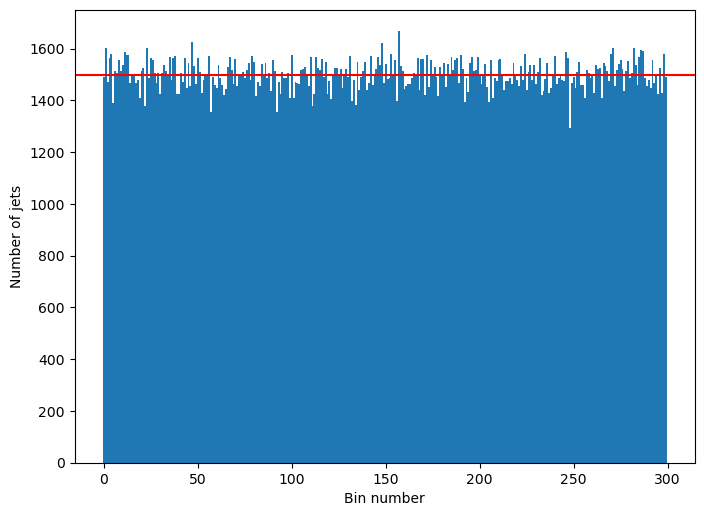

In [19]:
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.bar(np.arange(len(shuffled_bins_hist)), shuffled_bins_hist, width=1)
#plt.xlim(-1,21)
ax.set_xlabel("Bin number")
ax.set_ylabel("Number of jets")
ax.axhline(1500, c='r')
plt.show()


54.25241459040223
1500.0466666666666


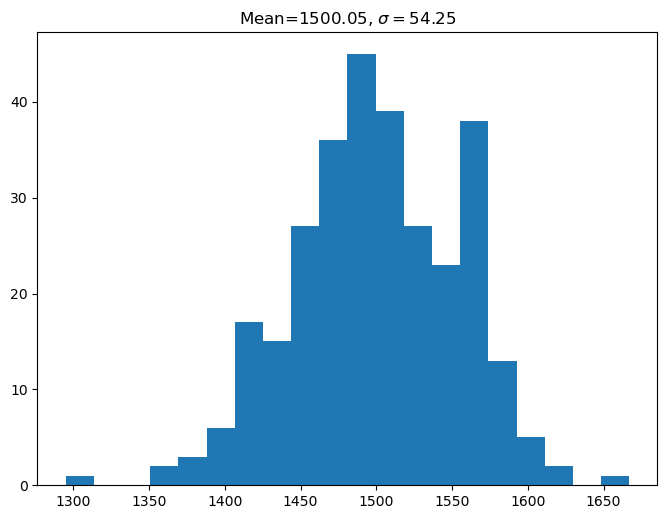

In [20]:
shuffled_mean = np.mean(shuffled_bins_hist)
shuffled_std_dev = np.std(shuffled_bins_hist)
print(shuffled_std_dev)
print(shuffled_mean)
x = np.linspace(1300, 1650, 100)
y = normal_dist(x, shuffled_mean, shuffled_std_dev)
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(shuffled_bins_hist, bins=20)
ax.set_title(r"Mean={:.2f}, $\sigma=${:.2f}".format(np.mean(shuffled_bins_hist), np.std(shuffled_bins_hist)))
#ax.plot(x, 30*y)
plt.show()

In [21]:
for i in range(450000):
    if (i % 45000 == 0):
        print(i/450000)
    for j in range(len(bins)):
        if (predict[450000+i, 0] >= shuffled_bins[j, 0] and predict[450000+i, 0] <= shuffled_bins[j, 4] and
            predict[450000+i, 1] >= shuffled_bins[j, 1] and predict[450000+i, 1] <= shuffled_bins[j, 5] and
            predict[450000+i, 2] >= shuffled_bins[j, 2] and predict[450000+i, 2] <= shuffled_bins[j, 6] and
            predict[450000+i, 3] >= shuffled_bins[j, 3] and predict[450000+i, 3] <= shuffled_bins[j, 7]):
            bins_hist[j] = bins_hist[j] + 1

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


300
447204.0
447204.0


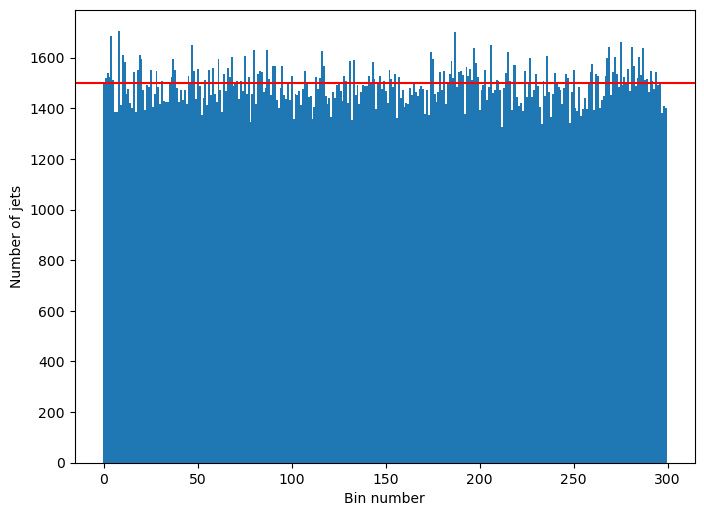

In [22]:
print(len(bins_hist))
print(len(bins_hist)*np.mean(bins_hist))
print(sum(bins_hist))
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.bar(np.arange(len(bins_hist)), bins_hist, width=1)
#plt.xlim(-1,21)
ax.set_xlabel("Bin number")
ax.set_ylabel("Number of jets")
ax.axhline(1500, c='r')
plt.show()

70.76489902015923
1490.68
447204.0


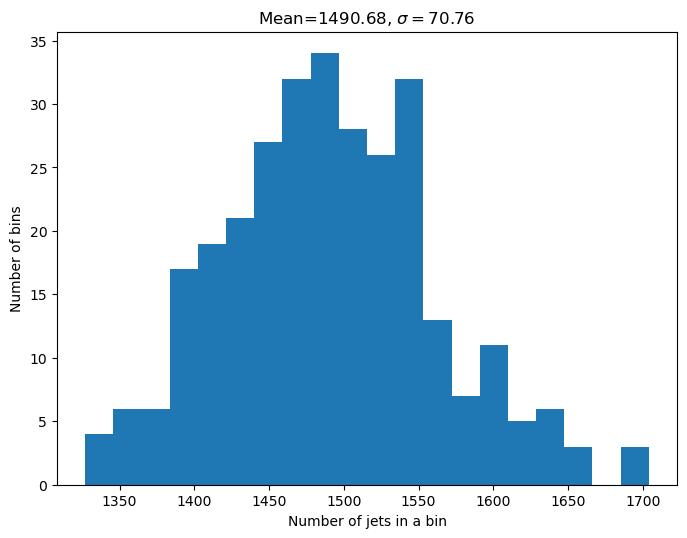

In [23]:
print(np.std(bins_hist))
print(np.mean(bins_hist))
print(np.mean(bins_hist)*len(bins_hist))
fig = plt.figure(figsize=(8,6), dpi=100)
ax = fig.add_subplot(111)
ax.hist(bins_hist, bins=20)
ax.set_xlabel("Number of jets in a bin")
ax.set_ylabel("Number of bins")
ax.set_title(r"Mean={:.2f}, $\sigma=${:.2f}".format(np.mean(bins_hist), np.std(bins_hist)))
plt.show()

In [ ]:
print(ks_2samp(bins_hist, shuffled_bins_hist))